In [1]:
import numpy as np
from matplotlib import pyplot as plt
import copy
import random
from scipy.linalg import sqrtm

In [2]:
#ASSIGNMENT 1
def kmeans(X, k, max_iter=100): 
    """ Performs k-means clustering

    Input:
    X: (d x n) data matrix with each datapoint in one column
    k: number of clusters
    max_iter: maximum number of iterations

    Output:
    mu: (d x k) matrix with each cluster center in one column
    r: assignment vector
    """
    # initailize k random centroids at data mean
    X_mean = np.mean(X, axis = 0)
    w_init = np.array([np.random.normal(X_mean[i],1,k) for i in range(len(X_mean))])
    w_q = w_init
    converged = False
    iteration = 1
    m_q = np.zeros(len(X))
    m_q_old = copy.deepcopy(m_q)
    while (not converged) & (iteration <= max_iter):
        # calculate distance to centroids
        D = np.linalg.norm(X[None, :] - w_q.T[:,None], axis = 2)
        # assign every data point to its nearest centroids
        m_q = np.argmin(D, axis=0)
        # assign random data point to not empty centroids
        m_empty = [x for x in range(k) if x not in np.unique(m_q)]
        for m in m_empty:
            m_q[random.randint(0,len(X)-1)] = m
        # calculate position of centroids as mean of assigned data
        w_q.T[np.unique(m_q)] = [np.sum(X[m_q == j], axis = 0) / (np.sum(m_q == j)) for j in np.unique(m_q)]
        
        # calculate objective
        loss = np.sum([np.sum((X[m_q == j, :] - w_q[:,j])**2) for j in np.unique(m_q)])
        print('iteration-step: ' + str(iteration))
        print('number of changes in assignment: ' + str(list(m_q == m_q_old).count(False)))
        print('loss function value: ' + str(loss))
        if (m_q == m_q_old).all():
            converged = True
            break
        
        m_q_old = copy.deepcopy(m_q)
        iteration+=1
    return w_q.T, m_q, loss

In [3]:
#ASSIGNMENT 2
def kmeans_agglo(X, r):
    """ Performs agglomerative clustering with k-means criterion

    Input:
    X: (d x n) data matrix with each datapoint in one column
    r: assignment vector

    Output:
    R: (k-1) x n matrix that contains cluster memberships before each step
    kmloss: vector with loss after each step
    mergeidx: (k-1) x 2 matrix that contains merge idx for each step
    """

    def kmeans_crit(X, r):
        """ Computes k-means criterion

        Input: 
        X: (d x n) data matrix with each datapoint in one column
        r: assignment vector

        Output:
        value: scalar for sum of euclidean distances to cluster centers
        """
        # calculate init centroids
        w_q = np.array([np.sum(X[r == j], axis=0) / (np.sum(r == j)) for j in np.unique(r)])
        # compute initial clustering cost
        loss = np.sum(
            [np.sum((X[r == j, :] - w_q.T[:, np.unique(r) == j].reshape(len(w_q.T))) ** 2) for j in np.unique(r)])
        return loss

    # initialization
    k = len(np.unique(r))
    n, d = np.shape(X)
    R = np.zeros((k - 1, n))
    kmloss = np.zeros((k, 1))
    mergeidx = np.zeros((k - 1, 2))

    kmloss[0] = kmeans_crit(X, r)

    for l in range(1, k):
        R[l - 1] = r
        # calculate init centroids
        w_q = np.array([np.sum(X[r == j], axis=0) / (np.sum(r == j)) for j in np.unique(r)])
        # calculate distance between centroids -> covariance matrix
        D = np.linalg.norm(w_q[None, :] - w_q[:, None], axis=2)
        # sort covariance ascending order
        pairs = list(zip(np.argsort(D, kind='mergesort', axis=None) // len(D),
                         np.argsort(D, kind='mergesort', axis=None) % len(D)))  # zeile / spalte
        # determine centroid pair with smallest loss, Caveat first elements are 0 explain the diagonal of the cov-matrix
        min_pair_idx = pairs[k - l + 1]
        # get names of merged clusters by r (clusters used before have the highest index plus 1 )
        min_pair = np.unique(r)[np.array(min_pair_idx)]
        mergeidx[l - 1] = min_pair
        # if np.isin(mergeidx[l-1, 0], mergeidx[:l-1]):
        #    mergeidx[l-1, 0] = k+l-1

        # new cluster membership
        r[np.isin(r, min_pair)] = k + l - 1
        # new kmloss
        kmloss[l] = kmeans_crit(X, r)
    return R, kmloss, mergeidx

In [4]:
#ASSIGNMENT 3
def agglo_dendro(kmloss, mergeidx):
    """ Plots dendrogram for agglomerative clustering

    Input:
    kmloss: vector with loss after each step
    mergeidx: (k-1) x 2 matrix that contains merge idx for each step
    """
    fourth_column = 2 * np.ones((len(mergeidx), 1))  # necessary for dendogram function, sample count
    Z = np.concatenate([mergeidx, kmloss[1:], fourth_column], axis=1)

    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
    )
    return

In [5]:
#Assignment 4
#now 100% accurate
def norm_pdf(X, mu, C):
    """
    This function computes the probability density function when given a multivariate gaussian distribution as an input.
    
    Input:
    X=data (nxd)
    mu=centre of Gaussian distribution (1xd)
    C=covariance matrix (nxn) , np.cov(X.T)
    
    Output:
    y=probability density function (nx1)

    """
    
    B = np.linalg.solve(C,(X-mu).T).T

    D = np.einsum('ji,ij->i',(X-mu).T,B)

    y = np.exp(-0.5*D) / (np.power((2*np.pi),X.shape[1]/2)*(np.linalg.det(C)**0.5))

    return y

In [6]:
#TEST CELL FOR ASSIGNMENT 4

X = np.array([[7,11],[10,1],[-5,5],[1,2],[99,1]])
mu = np.mean(X,axis=0)
C = np.cov(X.T)

import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

y=norm_pdf(X,mu,C)
print("Our output")
print(y) 

y = multivariate_normal.pdf(X, mu, C)
print("Correct output")
print(y)

X=np.array([[0,0],[1,3],[4,6],[-1,1],[0.5,1],[0.5,2],[1,7],[5,1],[7,1],[9,7]])
print(X.shape)

y = multivariate_normal.pdf(X, np.mean(X,axis=0), np.cov(X.T))
print("Correct output")
print(y)

z = norm_pdf(X,np.mean(X,axis=0),np.cov(X.T))
print("Our output")
print(z)

Our output
[0.00023031 0.00060937 0.00077062 0.00064296 0.0001957 ]
Correct output
[0.00023031 0.00060937 0.00077062 0.00064296 0.0001957 ]
(10, 2)
Correct output
[0.00970558 0.01602077 0.00982328 0.00977784 0.0134664  0.01508864
 0.0030866  0.00871177 0.00366591 0.00223946]
Our output
[0.00970558 0.01602077 0.00982328 0.00977784 0.0134664  0.01508864
 0.0030866  0.00871177 0.00366591 0.00223946]


In [7]:
#ASSIGNMENT 5

(9, 2)


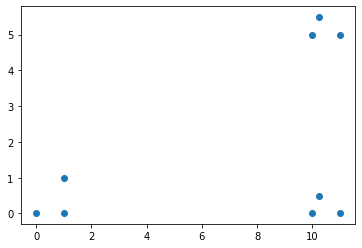

In [8]:
#from test.py
X = np.array([[0., 1., 1., 10., 10.25, 11., 10., 10.25, 11.],
            [0., 0., 1.,  0.,   0.5,  0.,  5.,   5.5,  5.]]).T
print(X.shape)
perfect_r = [1,0,1,2,2,1,2,2,2]

plt.scatter(X.T[0],X.T[1]) #this shows the clusters, for inspection checking EMM algorithm

In [34]:
#ASSIGNMENT 5 : COMPLETE
def em_gmm(X, k, max_iter=100, init_kmeans=False, tol=0.00001,converge_tol=0.0001):
    """
    This function applies the EM algorithm for Gaussian Mixture Models. 
    
    Inputs:
    X = data (nxd)
    k = number of gaussian components
    max_iter = the maximum amount of iterations attempted to find convergence
    init_kmeans = Initialises the EM algorithm using kmeans function, if True. Default is False.
    tol = The tolerance set for the convergence condition
    converge_tol = Tolerance for the convergence condition (optional)
    
    Outputs:
    pi = probability that a datapoint belongs to a cluster (1xk)
    mu = center points of clusters (kxd)
    sigma = list of k dxd covariance matrices
    loglik = the loglikehlihood at each iteration
    """
    
    if init_kmeans==True:
        #1.a INIT_KMEANS
        mu, r, _ = kmeans(X,k)
        unique, counts = np.unique(r, return_counts=True)
        pi = counts/np.sum(counts)
        
    else:
        #1.b RANDOM INITIALISATIONS
        pi = np.full(shape=(k,1), fill_value=1/k) #kx1
        rand_samples = np.random.choice(X.shape[0], size=(k,), replace=False) #choose k random data points
        mu = X[rand_samples] #centroid initialisation as random points, kxd
    
    
    #setup storage and loop
    sigma = [np.eye(X.shape[1]) for i in range(k)] #dxd
    likelihoods = np.zeros(shape=(X.shape[0],k),dtype=float) #nxk
    converged = False
    iteration = 1
    while (not converged) & (iteration <= max_iter):
    
        print('Iteration Number:\n',iteration)
    
        #2. E-STEP - compute new likelihoods and responsibilities
        old_likelihoods = copy.deepcopy(likelihoods)
        #print('Old likelihoods\n', old_likelihoods)
        
        #2.1 first find all k likelihoods
        for i in range(k):
            #nx1                             1x1 X nx1  = nx1 
            likelihood = (pi[i] * norm_pdf(X,mu[i],sigma[i])) #norm_pdf written to handle mu=(1xd) only
            likelihoods.T[i]=likelihood
        
        #CALC LOGLIK
        loglik = np.log(np.sum(likelihoods,axis=1)).sum()
        print('Loglikelihood\n',loglik)
    
        #2.2 use likelihoods to calculate individual k responsibilities
            #nxk            nxk              nx1
        responsibilities = likelihoods / np.sum(likelihoods, axis=1).reshape(likelihoods.shape[0],1)
    
        #3. M-STEP - compute new n,pi,mu,sigma
        #1xk
        n = np.sum(responsibilities,axis=0)
        #1xk
        pi = n / np.sum(n,axis=0)
        #kxd                    (nxkx0)x(nx0xd)=nxkxd --> kxd / kx1
        mu = np.sum(responsibilities[:,:,None]*X[:,None,:],axis=0)/n.reshape(n.shape[0],1)
        #kxdxd         =  sum ((nxkx0x0)     x    (nxkxdx0)x(nxkx0xd)) = nxkxdxd-->kxdxd/kx0x0
        sigma = np.sum(responsibilities[:,:,None,None]*(X[:,None,:,None]-mu[None,:,:,None])*(X[:,None,None,:]-mu[None,:,None,:]),axis=0) / n[:,None,None]
                                                    #   (nx0xdx0-nxkx0x0)-->(nxkxdx0)
        #add regularisation term, tol    
        sigma = sigma + tol*np.eye(X.shape[1])
    
        #break condition - only runs from second iteration to prevent log of old_likelihoods, which is 0 in iteration 1
        if iteration>1:
            if (np.log(np.sum(old_likelihoods,axis=1)).sum()-loglik).all()<converge_tol:
                converged=True

        iteration=iteration+1
        
    #return as a list of covariances    
    list_sigma=[sigma[i,:,:] for i in range(k)]
    return pi, mu, list_sigma, loglik

(9, 2)


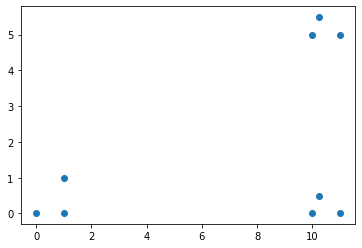

In [113]:
#from test.py
X = np.array([[0., 1., 1., 10., 10.25, 11., 10., 10.25, 11.],
            [0., 0., 1.,  0.,   0.5,  0.,  5.,   5.5,  5.]]).T
print(X.shape)
perfect_r = [1,0,1,2,2,1,2,2,2]

plt.scatter(X.T[0],X.T[1]) #this shows the clusters, for inspection checking EMM algorithm

In [114]:
pi, mu, sigma, loglik = em_gmm(X,k=3,tol=0.00001)

Iteration Number:
 1
Loglikelihood
 -59.36414317283165
Iteration Number:
 2
Loglikelihood
 -26.45362499277262
Iteration Number:
 3
Loglikelihood
 -25.57106988022097
Iteration Number:
 4
Loglikelihood
 -22.219555731180527
Iteration Number:
 5
Loglikelihood
 -20.33095928245402
Iteration Number:
 6
Loglikelihood
 -16.510734111958307
Iteration Number:
 7
Loglikelihood
 -16.438255287188053
Iteration Number:
 8
Loglikelihood
 -16.438255287188053


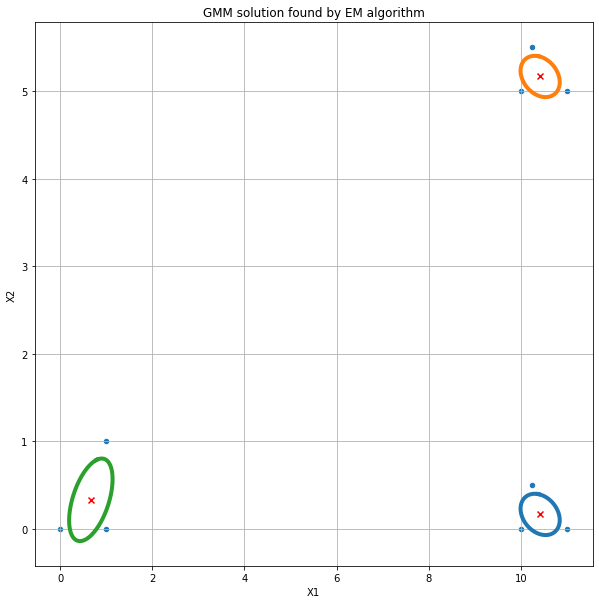

In [115]:
#ASSIGNMENT 6 DEV CELL

#ASSIGNMENT 6 GMM PLOT
plt.figure(figsize=(10,10))
plt.scatter(X.T[0],X.T[1],s=20)
plt.title('GMM solution found by EM algorithm')
plt.ylabel('X2')
plt.xlabel('X1')
plt.grid(True)


#draw ellipse
for i,sig in enumerate(sigma):
    tline = np.linspace(0, 2 * np.pi, 100)
    sphere = np.vstack((np.sin([tline]), np.cos([tline])))
    ellipse = sqrtm(sig).dot(sphere)
    plt.plot(mu[i][0] + ellipse[0, :], mu[i][1] + ellipse[1, :],linewidth=4)
    #plot centre points
    plt.scatter(mu[i][0],mu[i][1],c='r',marker='x')

In [116]:
#ASSIGNMENT 6 GMM PLOT ---> NEEDS SCIPY.LINALG.SQRTM
def plot_gmm_solution(X,mu,sigma):
    """
    This function plots the different gaussians found by the EM algorithm as ellipses centred around the distributions' means.
    
    Input:
    X=data (nxd)
    mu=distribution centres (kxd)
    sigma=list of k dxd covariance matrices
    
    """
    #plot data points and setup plot parameters
    plt.figure(figsize=(10,10))
    plt.scatter(X.T[0],X.T[1],s=20)
    plt.title('GMM solution found by EM algorithm')
    plt.ylabel('X2')
    plt.xlabel('X1')
    plt.grid(True)


    #draw ellipse
    for i,sig in enumerate(sigma):
        tline = np.linspace(0, 2 * np.pi, 100)
        sphere = np.vstack((np.sin([tline]), np.cos([tline])))
        ellipse = sqrtm(sig).dot(sphere)
        plt.plot(mu[i][0] + ellipse[0, :], mu[i][1] + ellipse[1, :],linewidth=4)
        #plot centre points
        plt.scatter(mu[i][0],mu[i][1],c='r',marker='x')

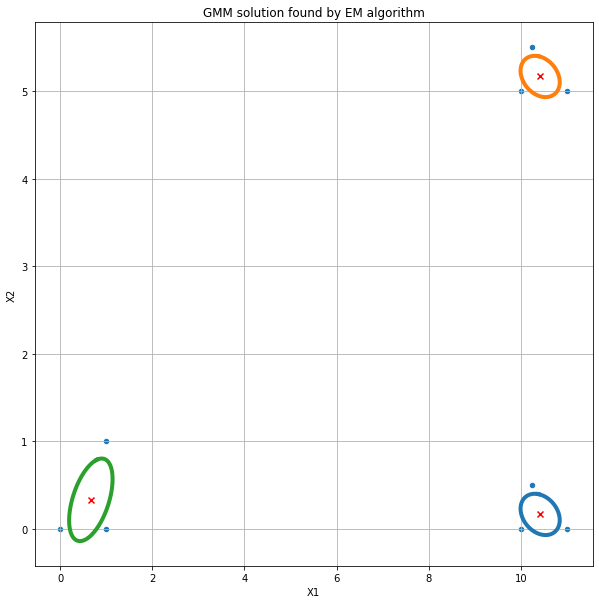

In [117]:
plot_gmm_solution(X,mu,sigma)